# Zaawansowane Metody Inteligencji Obliczeniowej
## Lab 8: Q-Learning z aproksymacją
### Prowadzący: Michał Kempka, Marek Wydmuch

## Wprowadzenie

Celem tego ćwiczenia jest implementacja algorytmu Q-Learning z aproksymacją dla środowiska `CartPole` ze znanej Wam już bibliteki OpenAI Gym (https://gym.openai.com).


Zapoznaj się z opisem środowiska (https://gym.openai.com/envs/CartPole-v1) następnie zapoznaj się z kodem poniżej. Pokazuje on przykład użycia omawianego środowiska.

In [ ]:
# Zainstaluj bibliotekę OpenAI Gym i PyTorch
!pip install gym torch matplotlib numpy
# W wypadku problemów z działąniem na macOS Big Sur uruchom również poniższą linię
#!pip install pyglet==1.5.15

### Środowisko `CartPole`

Poniższy kod demonstruje działanie środowiska `CartPole`

In [8]:
# Zobacz jak działa środowisko na przykładzie 1000 kroków
import gym

env = gym.make("CartPole-v1")
observation = env.reset()
for _ in range(1000):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info, _ = env.step(action)

    if done:
        observation = env.reset()
env.close()

/home/teba_dzdancewicz/.local/lib/python3.11/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
/home/teba_dzdancewicz/.local/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [9]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Ostatnia obserwacja:", observation)
print("Przestrzeń akcji:", env.action_space)

Przestrzeń stanów: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Ostatnia obserwacja: [-0.05765169 -0.41444802  0.03035248  0.552756  ]
Przestrzeń akcji: Discrete(2)


### Regresja w PyTorch

Poniższy kod demosntruje jak stworzyć prosty model za pomocą bilibteki PyTorch dla problemu regresji.

In [10]:
import torch
import torch.nn.functional as F

class MyModel(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(MyModel, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)  # Warstwa wejściowa
        self.predict = torch.nn.Linear(n_hidden, n_output)  # Warstwa wyjściowa

    # W momencie wykonania tych operacji zostanie stworzony graf obliczeniowy, który zostanie wykorzystany do propagacji wstecznej
    def forward(self, x):
        x = F.relu(self.hidden(x))  # Wejście + funkcja aktywacji
        x = self.predict(x)         # Liniowe wyjście
        return x

h = MyModel(n_feature=1, n_hidden=50, n_output=1)

# Poza samym modelem, w celu jego uczenia potrzebujemy optymalizatora (w tym wypadku algorytmu SGD)
optimizer = torch.optim.SGD(h.parameters(), lr=0.2)

# Oraz naszej funkcji straty, w tym wypadku błędu kwadratowego
loss_func = torch.nn.MSELoss()

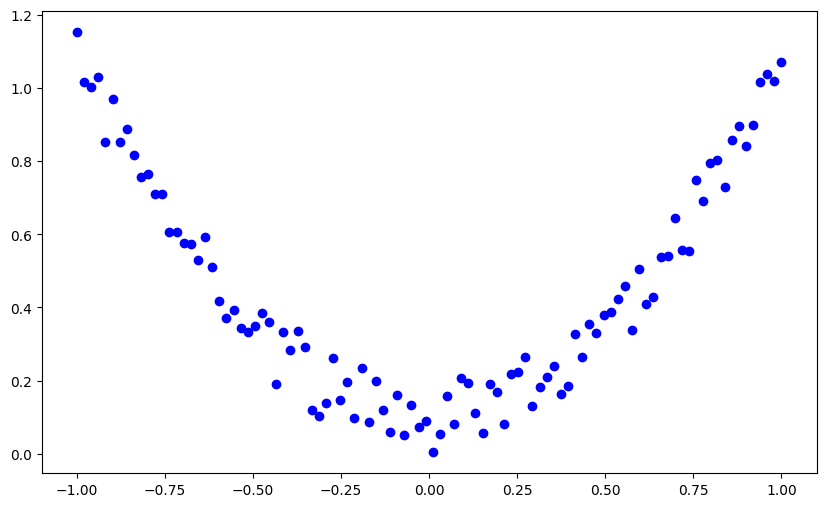

In [11]:
# Stwórzmy przykładowe, jednowmiarowe dane i wyświetlmy je
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
y = x.pow(2) + 0.2 * torch.rand(x.size())

plt.figure(figsize=(10,6))
plt.scatter(x.data.numpy(), y.data.numpy(), color="blue")
plt.show()

In [12]:
# Wytrenujmy nasz model wykonując 1000 iteracji po całym zbiorze danych
for t in range(1000):
    # Dokonaj predykcji na podstawie x
    prediction = h(x) 
    
    # Wyliczmy błąd
    loss = loss_func(prediction, y)
    
    # Wyzerujmy gradienty
    optimizer.zero_grad()
    
    # Wylicz gradienty dla każdej operacji z użyciem propagacji wstecznej
    loss.backward()

    # Zaktualizuj wagi
    optimizer.step()

In [13]:
# Wykonajmy ostateczną predykcję, nie potrzebujemy już gradientów ani grafu obliczeniowego
with torch.no_grad():
    prediction = h(x)

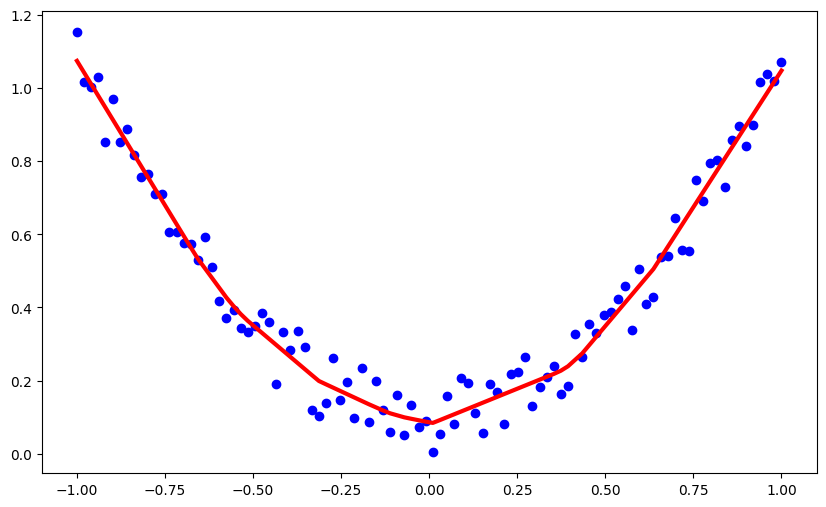

In [14]:
# Wyświetlmy wyniki
plt.figure(figsize=(10,6))
plt.scatter(x.data.numpy(), y.data.numpy(), color="blue")
plt.plot(x.data.numpy(), prediction.data.numpy(), color="red", lw=3)
plt.show()

## Ćwiczenie: zaimplementuj algorytm Q-Learning z aproksymacją dla środowiska `CartPole`